<h1 style="text-align: center">The story of book covers</h1>

<div style="text-align: center">ADA Team Project - Fall 2017</div>
<div style="text-align: center">Nataljia Gucevska, Sébastien Chevalley, Alexis Montavon</div>

<div id="toc"></div>

# Goal 

For this project, we set the very broad goal as following: finding insights about book covers and how they are related to their categories, publish date and sales ranking. Can we predirect the category or the year of a book given its cover? Or is there any *book cover fashion* in the publishing industry.

In [47]:
%load_ext autoreload
%autoreload 2

import json
import re
import pickle
import random
import itertools
import cv2

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data

from scipy.cluster.hierarchy import fcluster,linkage
from scipy.sparse.csr import csr_matrix 

from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import StratifiedKFold
from keras.layers import Input, Dense, Dropout
from keras.models import Model

import os.path

from utils import *
from urllib import parse
from math import ceil
from collections import Counter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data scraping and dataset statistics

## Description of the Amazon dataset

We started this project by obtaining the Amazon dataset about books and their cover. The information on book covers are given as 4096 float vector representation computed from a Neural network. But most of the information contained about the books is pretty unrelevant for acheiving our goal. The brands and categories given are useless, the description and prices are sparse.

Examples on the amazon's website told us Metadata contained sales rank, categories and unique identifier. We quickly found out that for books, they were only one category: "Books" (and some of the records in the file were not in this category)

In [2]:
meta_book_df = pd.read_json('output.strict', lines=True)
meta_book_df.head()

,asin,brand,categories,description,imUrl,price,related,salesRank,title
0,0001048791,NaN,[[Books]],NaN,http://ecx.images-amazon.com/images/I/51MKP0T4...,NaN,NaN,{'Books': 6334800},"The Crucible: Performed by Stuart Pankin, Jero..."
1,0001048775,NaN,[[Books]],William Shakespeare is widely regarded as the ...,http://ecx.images-amazon.com/images/I/5166EBHD...,NaN,NaN,{'Books': 13243226},Measure for Measure: Complete &amp; Unabridged
2,0001048236,NaN,[[Books]],"&#34;One thing is certain, Sherlockians, put a...",http://ecx.images-amazon.com/images/I/51DH145C...,9.26,"{'also_viewed': ['1442300191', '9626349786', '...",{'Books': 8973864},The Sherlock Holmes Audio Collection
3,0000401048,NaN,[[Books]],NaN,http://ecx.images-amazon.com/images/I/41bchvIf...,NaN,{'also_viewed': ['068240103X']},{'Books': 6448843},The rogue of publishers' row;: Confessions of ...
4,0001019880,NaN,[[Books]],NaN,http://ecx.images-amazon.com/images/I/61LcHUdv...,5.39,"{'also_viewed': ['B003HMB5FC', '0834004593'], ...",{'Books': 9589258},Classic Soul Winner's New Testament Bible


We decided to enchance the important data we had (asin number, image url, sales information) with another dataset that could give us the publication date, language in the purpose of filtering and a some better categories. We turned to the [OpenLibrary](https://openlibrary.org) dataset to do so.

We are going to use the sales information in order to study the popularity of a book instead of the user reviews, to start at least. But we still have this dataset and it can be match with the asin number easily if we choose to use it later on. We think is is a good idea to start because: 1. we think that once we cluster books into their respective categories, they may be a clearer rank indicator than reviews 2. it is easier to get started without having ot join reviews.

We picked OpenLibrary as a source because we found out that using the API provided by Amazon to get metadata about a book is very rate-limited (less than 10k requests a day) and we have more than 2M books. Even with 1M books, around 5 differents IPs address, it would still take twenty days, more than the time we would have. Plus, OpenLibrary provides dump

## Description of the OpenLibrary dataset

Size: 26.3 GB

Here is the information given for a book in this dataset. We have the language, the publication date, multiple type of identifiers to match both dataset (more about this in the next part) and different subjects as well as two classifiers, the [Library of Congress Classification](https://en.wikipedia.org/wiki/Library_of_Congress_Classification) and the [Dewey Decimal Classification](https://en.wikipedia.org/wiki/Dewey_Decimal_Classification).

In [3]:
num = 0
with open("ol_dump_editions_latest.txt", "r") as f:
    for l in f:
        book = json.loads(l.split("\t")[-1])
        print(book)
        break

{'publishers': ['Bernan Press'], 'physical_format': 'Hardcover', 'subtitle': '9th November - 3rd December, 1992', 'key': '/books/OL10000135M', 'title': 'Parliamentary Debates, House of Lords, Bound Volumes, 1992-93', 'identifiers': {'goodreads': ['6850240']}, 'isbn_13': ['9780107805401'], 'languages': [{'key': '/languages/eng'}], 'number_of_pages': 64, 'isbn_10': ['0107805405'], 'publish_date': 'December 1993', 'last_modified': {'type': '/type/datetime', 'value': '2010-04-24T17:54:01.503315'}, 'authors': [{'key': '/authors/OL2645777A'}], 'latest_revision': 4, 'works': [{'key': '/works/OL7925046W'}], 'type': {'key': '/type/edition'}, 'subjects': ['Government - Comparative', 'Politics / Current Events'], 'revision': 4}


Here is all the possible keys available for a book. We found duplicates and spelling mistakes. The key takeaway here is that the database quality is overall good because when we spent time to add the missing fields or the mispelled field we always added less than ten thousands records over a million.

In [17]:
{'author_names', 'authors', 'birth_date', 'body', 'bookweight', 'by_statement', 'by_statements', 'classifications', 'code', 'collections', 'contributions', 'contributors', 'copyright_date', 'coverid', 'coverimage', 'covers', 'create', 'created', 'description', 'dewey_decimal_class', 'dewry_decimal_class', 'dimensions', 'download_url', 'edition', 'edition_name', 'first_sentence', 'full_title', 'genres', 'ia_box_id', 'ia_id', 'ia_loaded_id', 'identifiers', 'isbn', 'isbn_10', 'isbn_13', 'isbn_invalid', 'isbn_odd_length', 'key', 'language', 'language_code', 'languages', 'last_modified', 'latest_revision', 'lc_classification', 'lc_classifications', 'lccn', 'library_of_congress_name', 'links', 'location', 'm', 'macro', 'name', 'news', 'notes', 'number_of_pages', 'numer_of_pages', 'ocaid', 'oclc_number', 'oclc_numbers', 'openlibrary', 'original_isbn', 'other_titles', 'pagination', 'physical_dimensions', 'physical_format', 'price', 'publish_country', 'publish_date', 'publish_places', 'publishers', 'purchase_url', 'remote_ids', 'revision', 'scan_on_demand', 'scan_records', 'series', 'source_records', 'stats', 'subject_people', 'subject_place', 'subject_places', 'subject_time', 'subject_times', 'subjects', 'subtitle', 'table_of_contents', 'title', 'title_prefix', 'translated_from', 'translation_of', 'type', 'uri_descriptions', 'uris', 'url', 'volume_number', 'volumes', 'vorks', 'weight', 'work_title', 'work_titles', 'works'}

{'author_names',
 'authors',
 'birth_date',
 'body',
 'bookweight',
 'by_statement',
 'by_statements',
 'classifications',
 'code',
 'collections',
 'contributions',
 'contributors',
 'copyright_date',
 'coverid',
 'coverimage',
 'covers',
 'create',
 'created',
 'description',
 'dewey_decimal_class',
 'dewry_decimal_class',
 'dimensions',
 'download_url',
 'edition',
 'edition_name',
 'first_sentence',
 'full_title',
 'genres',
 'ia_box_id',
 'ia_id',
 'ia_loaded_id',
 'identifiers',
 'isbn',
 'isbn_10',
 'isbn_13',
 'isbn_invalid',
 'isbn_odd_length',
 'key',
 'language',
 'language_code',
 'languages',
 'last_modified',
 'latest_revision',
 'lc_classification',
 'lc_classifications',
 'lccn',
 'library_of_congress_name',
 'links',
 'location',
 'm',
 'macro',
 'name',
 'news',
 'notes',
 'number_of_pages',
 'numer_of_pages',
 'ocaid',
 'oclc_number',
 'oclc_numbers',
 'openlibrary',
 'original_isbn',
 'other_titles',
 'pagination',
 'physical_dimensions',
 'physical_format',
 'price

There is also a key `identifiers` which is used to store various kind of identification in addition of ISBN. We found in it an Amazon field which could contains from Amazon identifiers to URL. Extracting them took times but was not usefull (added less than 400 books in the next step). This field identifiers contained less than 200 unique kinds of identifiers.

## Matching the two datasets

So we needed to match Amazon data with ASIN and OpenLibrary data which containes different type of identifiers (including some Amazon identifiers)

We found out that ASIN (Amazon product identifier) is in fact ISBN-10 for books. We first tried to match data based on this information. We also tried to extract amazon identifier from other field in the OpenLibrary dataset but only found less than 5'000 new records to add.

We removed data from the Amazon dataset where we have no sales ranking data because we want to be able to compare popularity or if there is is no link to the image cover as we want to compare visually the similarity. Most of the removal (less than 500'000 records) are dropped because of missing sales ranking information.

From the OpenLibrary dataset we removed the records if there is no ISBN, language, date or topics. Language because we expect to keep only English books because of cultural difference (what is trendy in English-speaking field is not what is treandy in other languages, we think there is some boundaries because of language). Also, we removed records because of publish dates because we have temporal bias to take in account and we want to be able to filter at least by year and see if there exists different trends in different times. Altough we could fill the hole for the language, date or topics (by scraping other website or amazon itself), ISBN is mandatorsy since its purpose is primary key to do the join operation. Other field could be filled up later if our dataset is too narrow.

## In practice

* We first tried different option to join the datasets. One key point for our exploratory analysis was to to be **lean**. * Very firstly we tried to import both dataset as dataframe, but it took way too much for the 32GB main memory machine we had access to.
* But for our next experiments we first exported the set of ASIN of the Amazon dataset (~47MB) and then tried various solution to extract identifiers from the OpenLibrary dataset
    * First one was fuzzy matching using "Amazon:" and "ISBN:" per-line grep search. It did not yield any significant results but allowed us to not parse the JSON
    * Second one was parsing the JSON and export Amazon identifiers we found out in the file, join result size was near 80'000 books matched. Not enough!
    * We found out during our research that ASIN were in fact ISBN and this time parsed the JSON and exported all ISBN (10, 13 and ASIN) from it. We got around 1 millions matches
* We implemented a script using the multiprocessing package from Python to read line from files and then using multiple workers to parse the JSON. Even on an spinning drive, without multiprocessing, the script was not IO-bound but CPU bound.
* Once we got better result and more responsive times we started to export other fields and did filtering as explained before

The matching has been done the following. Instead of reimplementing Panda's feature. We built two dataframes, one per dataset with the following columns:

* for Amazon dataset: 1. Row number in the file, 2. ASIN
* for OpenLibrary dataset: for each identifiers of a given book, 1. Row number in the file, 2. Identifier found

So we could have more than one row per book in the OpenLibrary Dataframe.

From that, we used the merge method from Pandas to join together both dataset. We when joined on each side remaining information and built a new dataset. We merged together data from OpenLibrary and tried to detect mismatch (two different languages or publish_date)

In [22]:
with open('merged_data.pickle', 'rb') as f:
    merged_data = pickle.load(f)
merged_df = pd.DataFrame(merged_data)
merged_df.head()

,asin,image_url,languages,publish_date,sales_rank,subjects
0,0000401048,http://ecx.images-amazon.com/images/I/41bchvIf...,[eng],1974,6448843.0,"[Publishers and publishing, United States]"
1,0001019880,http://ecx.images-amazon.com/images/I/61LcHUdv...,[eng],October 2000,9589258.0,"[Other Translations - General, Bibles, Bibles ..."
2,0001057170,http://ecx.images-amazon.com/images/I/51M65KR8...,[eng],"September 1, 2000",9318563.0,"[Humour, Humor, English, Audio Adult: Other, G..."
3,0001053396,http://ecx.images-amazon.com/images/I/51WTKK4V...,[eng],September 1999,12249714.0,"[Poetry texts & anthologies, Poetry, Abridged ..."
4,0001053744,http://ecx.images-amazon.com/images/I/712C-G3X...,[eng],"January 1, 2001",5665835.0,"[Works by individual poets: classical, early &..."


## Insight about the data

### Publication dates

Here we inspect the books by publication date. Pay attention of the data peak around 2007. It is not because books became not trendy and lost all the sales, but the reason is that in 2007, book publishers have transitioned from ISBN10 to EAN13. And we can see that in the data.

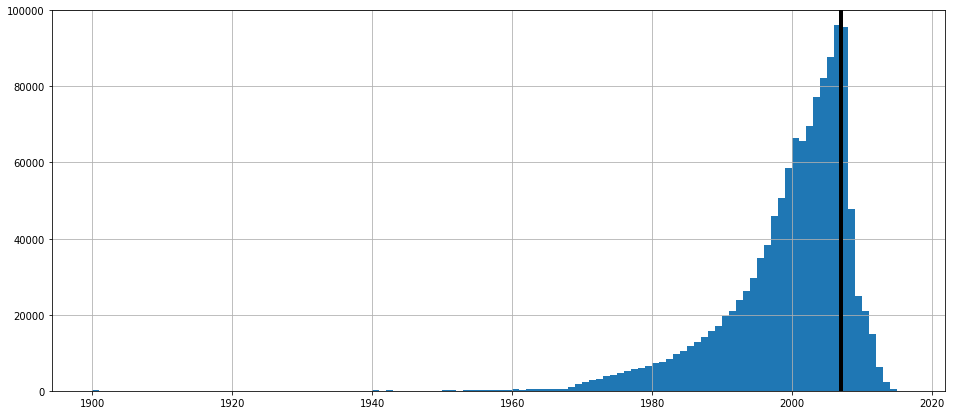

In [23]:
year_p = re.compile("[0-9]{4}")

# remove non 4 digits year in publish date (81 rows removed over 1.3M)
merged_df = merged_df[merged_df["publish_date"].map(lambda x: len(year_p.findall(x)) == 1)]
merged_df = merged_df[merged_df["languages"].map(lambda x: "eng" in x)]
merged_df["publish_date"] = merged_df["publish_date"].map(lambda x: int(year_p.findall(x)[0]))

merged_df["publish_date"].hist(bins=range(1900,2017), figsize=(16,7))
plt.plot([2007,2007], [0,100000], linewidth=4, color="k")
plt.ylim((0,100000))
plt.show()

### Subjects

Since categories from subjects in the OpenLibrary dataset are very hard to read and so diverse `597'493` different categories, we chose to work with the Library of Congress classification and/or the Dewey classification. From now on we will drop the `subjects` information as it does not provide any information for us.
Below we show only 20 different subjects that appear in the information `from OpenLibrary`

In [25]:
subjects_list = []
for subjects in merged_df["subjects"].values.tolist():
    for subject in subjects:
        subjects_list.append(subject)
frequencies = pd.Series(subjects_list).value_counts()

df_hist = pd.DataFrame(frequencies)
df_hist.columns = ["count"]
df_hist.head(n=20)

,count
General,109883
Fiction,102776
History,48923
Religion,40365
United States,31914
Juvenile Fiction,24352
Reference,23091
Protected DAISY,22791
Fiction - General,21782
Juvenile Nonfiction,21018


### LoC & Dewey classifications

As we said before we want to use a more general classification for our books the Library of Congress and Dewey Decimal classifications let us do so. Below we display the two classifications: The first data frame presents the Library of congress classification and the second data frame presents the Dewey Decimal classification. 

As the Library of Congress classification is a bit more detailed than the Dewey Decimal and there is more data with the first one, we selected this classification for our project. We will match this classification to the filtered dataset. In order to keep some coherence we will only take data entries that have the Library of Congress classification.

In [26]:
lc_class = pd.read_csv('lcClassification.csv')
lc_class

,Letter,Subject area
0,A,General Works
1,B,"Philosophy, Psychology, and Religion"
2,C,Auxiliary Sciences of History
3,D,General and Old World History
4,E,History of America
5,F,"History of the United States and British, Dutc..."
6,G,"Geography, Anthropology, and Recreation"
7,H,Social Sciences
8,J,Political Science
9,K,Law


In [27]:
dewey_class = pd.read_csv('deweyClassification.csv', names=['Interval', 'Subject Area']).drop(0, axis=0)
dewey_class

,Interval,Subject Area
1,000,Computer science / information & general works
2,100,Philosophy & psychology
3,200,Religion
4,300,Social sciences
5,400,Language
6,500,Pure Science
7,600,Technology
8,700,Arts & recreation
9,800,Literature
10,900,History & geography


In [47]:
filtered_df = pd.read_pickle('filtered_merge_data.pickle')
filtered_df.head()

,asin,dewey,image_url,languages,lc,publish_date,sales_rank,category
40,0001837192,"{759.9493, eng}",http://ecx.images-amazon.com/images/I/913JcEhB...,{eng},"{eng, ND673.B74 C7 1975b}",{1975},5555643.0,Fine Arts
48,0001839225,"{[E], eng}",http://ecx.images-amazon.com/images/I/61qIWAs9...,{eng},"{PZ7.B25058 Sp 1995, eng}","{1995, 1980}",738272.0,Language and Literature
55,0001714538,"{428.6, eng}",http://ecx.images-amazon.com/images/I/A1zj84uC...,{eng},"{PE1119, eng}",{1985},1397256.0,Language and Literature
64,0001847775,{eng},http://ecx.images-amazon.com/images/I/51CGeo4B...,{eng},"{PZ7.G18417 St, eng}",{1976},13408595.0,Language and Literature
66,0001950584,"{746.44/20433/0942, eng}",http://ecx.images-amazon.com/images/I/61-4Su3Y...,{eng},"{eng, NK3049.B3 D4 1988}","{1984, 1988}",1019744.0,Fine Arts


In [6]:
with open('final_dataset.pickle', 'rb') as f:
    final_data = pickle.load(f)  
    
main_dataset = pd.DataFrame.from_dict(final_data, orient='index')

In [7]:
del final_data

### Image downloading and processing

The features vectors are practical and are way lighter than a current image. But the process that generated them [TODO add reference] was targeted to clothes and fashion objects. We thought that it may not represent accurately a book cover. To circumvent that we decided to work on the covers themselves. Therefore, we have produced a list of file to download in parallel with [`aria2c`](https://aria2.github.io/).

Once downloaded, it resulted in a 34.3 GB dataset. We have inspected our images and found out that there were not a single aspect ratio neither a common height or width. Here is the distribution of the cover dimensions.

Then we have to reduce the size. We decided, given this statistics and most of the requirements of image size in various convolutation networks to stop at 256x256x3. The figure show us that at least 75% of our images were compatible with this format. And only a small percentage (3% will be upscaled).

We then used ImageMagick to resize all images to 256x256 and we had to decide either to keep the aspect ratio of the images or to force the resize. We decided to keep aspect ratio and add white background when necessary. For further reference, here is the command we used:

```bash
find . -maxdepth 1 -type f -print0 | xargs -0 -n 1 -P 4 -I FILE convert FILE -resize 256x256 -gravity center -background "rgb(255,255,255)" -extent 256x256 resized/FILE```

In [6]:
#with open("url.txt", "w") as f:
#    for x in main_dataset["image_url"].values:
#        f.write(x)
#        f.write("\n")

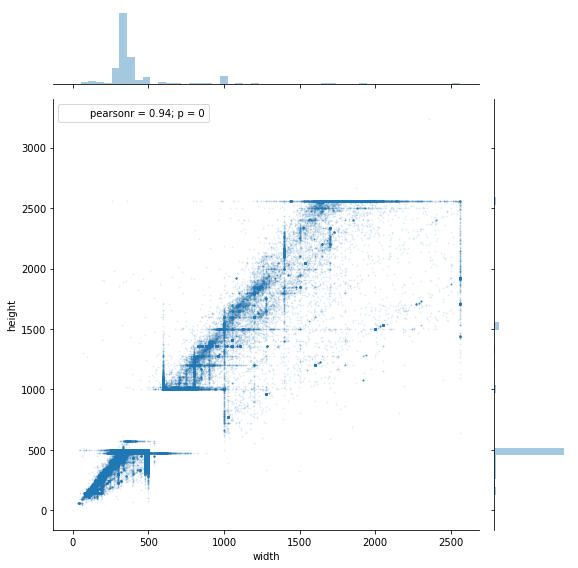

,width,height
count,397108.000000,397108.000000
mean,477.650548,662.436629
std,366.906463,479.728455
min,35.000000,41.000000
25%,318.000000,475.000000
50%,337.000000,500.000000
75%,405.000000,500.000000
max,2560.000000,3240.000000


In [8]:
# Code which generate a scatter plot of all width x height values
# of downloaded images
# TODO, this code is dependent of the output of dimensions.txt files in filtered cover directory
ws = list()
hs = list()
whs = list()

for slice_index in range(1,5):
    # TODO: move this dimensions.txt file in another directory for final
    filename = "filtered_cover/slice{}/dimensions.txt".format(slice_index)

    with open(filename, "r") as f:
        for line in f:
            w, h = [int(x) for x in line.strip().split("x")]
            ws.append(w)
            hs.append(h)
            whs.append([w,h])

df = pd.DataFrame(whs, columns=["width", "height"])

sns.jointplot(x="width", y="height", data=df, s=0.75, alpha=0.1, size=8)
plt.show()
df[(df["height"] > 1) & (df["width"] > 1)].describe()

In [9]:
smaller_than_requirement = len(df[(df["height"] < 256) & (df["width"] < 256)])
ratio = smaller_than_requirement / len(df) * 100

"{:.2f}% of the images are smaller than the requirements".format(ratio)

'3.55% of the images are smaller than the requirements'

In [10]:
half_smaller = len(df[(df["height"] < 128) & (df["width"] < 128)])
ratio = half_smaller / len(df) * 100


"{:.2f}% of the images will be upscaled at least twice the size".format(ratio)

'0.13% of the images will be upscaled at least twice the size'

# Data analysis

## Load data containing asin, features, category, cover image, publish_date and sales_ranking for around 400 000 books

This pickle file was generated using the script `generate.py`

In [78]:


df = main_dataset

df.head()
df.category.fillna('None', inplace=True)

asins = df.index.values
features = df.features.values
category = df.category.values
publish_date = df.year.values
sales_rank = df.sales_rank.values

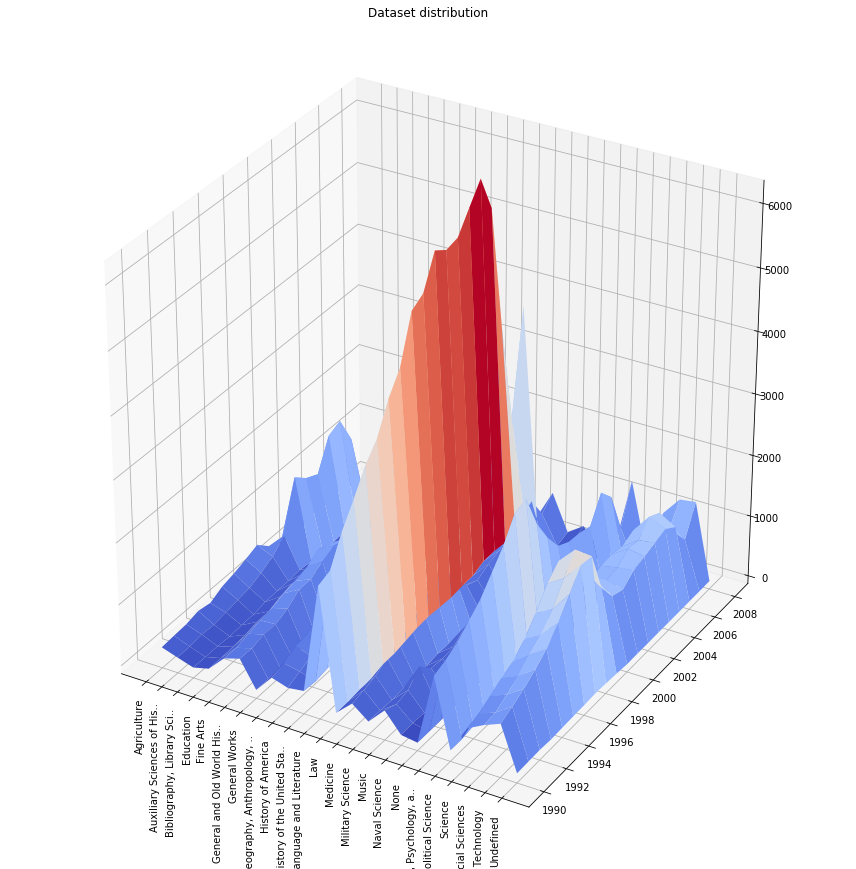

In [79]:
# This is boilerplate code to do operations on cluster
# we just move it on a file to avoid adding noise on the notebook
from cluster_utils import load_data, plot_3d

graph_data = load_data(df)
Z_total = graph_data[0]
    
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plt.tight_layout()
plot_3d(ax, Z_total, "Dataset distribution", graph_data)
plt.show()

## Clustering by book cover 

We start our data analysis by clustering the books by cover. Using the data from library of congress and open library we can see if the books of specific categories appear in the same clusters. This will allow us to see if there is a link between the book categories, year of publishing or sales rating and the covers.

### Aglomerative clustering

Not knowing the number of clusters, we decided to use aglomerative clustestering. Also for this part, we decided to use small fraction of the available data before starting with deeper and longer analysis. 

#### Dominant categories by cluster 

##### Equalize dataset by category

Here we make sure that every category has aproximately the same number of books, in this case around 4000. The books we keep in each category are chosen randomly. 

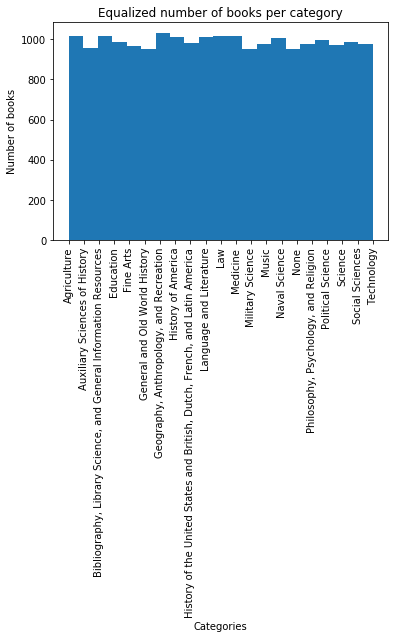

In [7]:
eq_asins, eq_features, eq_category, eq_publish_date, eq_sales_rank = \
equalize_by_category(asins, features, category, publish_date, sales_rank, num_by_category=1000)

info = np.unique(eq_category)

plt.title('Equalized number of books per category')
n, bins, patches = plt.hist(eq_category, bins=len(info))
plt.xticks(rotation=90)
plt.ylabel('Number of books')
plt.xlabel('Categories')
plt.show()

##### PCA 

In [8]:
#Number of important components to keep
n_components = 100
pca = PCA(n_components=n_components)
X = pca.fit_transform(eq_features)

##### Cluster the chosen features

The clustering is done using aglomerative clustering and the number of clusters can be easily modified. For our analyzis we chosed to keep 30 clusters, in order to inspect clusters with dominant category.  

In [ ]:
Z = linkage(X, "ward")

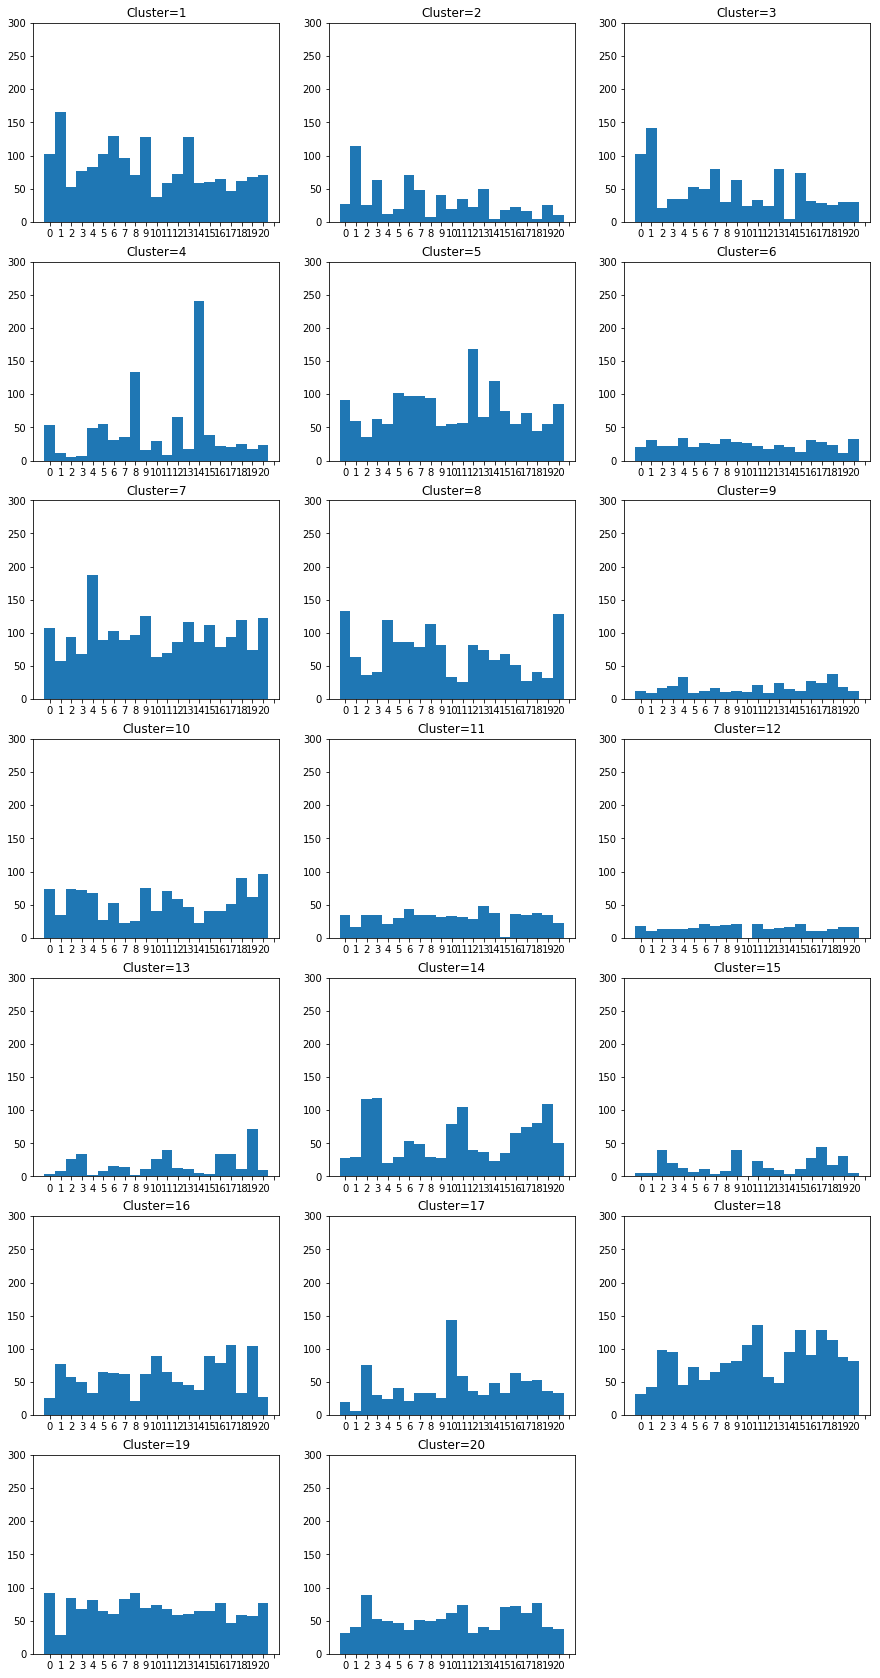

In [21]:
k=20
clusters = fcluster(Z, k, criterion='maxclust')
plot_by_cluster(clusters, eq_category)

##### Comment on results 

On the previous plots we can easily see that there are clusters that contain elements from specific categories such as clusters 2,3,4, 13 and 17. Also there are clusters that have mixed distribution of categories but have complete abscence of one caefory such as clusters 15, 11 and 12. 

This leads us to the conclusion that indeed, covers and books categories are correlated in some way and we will explore this further using lenear classifiers and neural networks. 

### Trends

#### Equalize dataset by publish date 

47


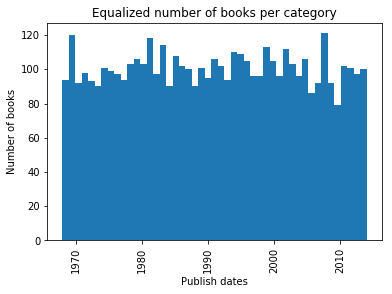

In [35]:
eq_asins, eq_features, eq_category, eq_publish_date, eq_sales_rank = \
equalize_by_year(asins, features, category, publish_date, sales_rank, num_by_category=100)

info = np.unique(eq_publish_date)
print(len(info))

plt.title('Equalized number of books per category')
n, bins, patches = plt.hist(eq_publish_date, bins=len(info))
plt.xticks(rotation=90)
plt.ylabel('Number of books')
plt.xlabel('Publish dates')
plt.show()

#### PCA 

In [36]:
#Number of important components to keep
n_components = 100
pca = PCA(n_components=n_components)
X = pca.fit_transform(eq_features)

#### Cluster the chosen features

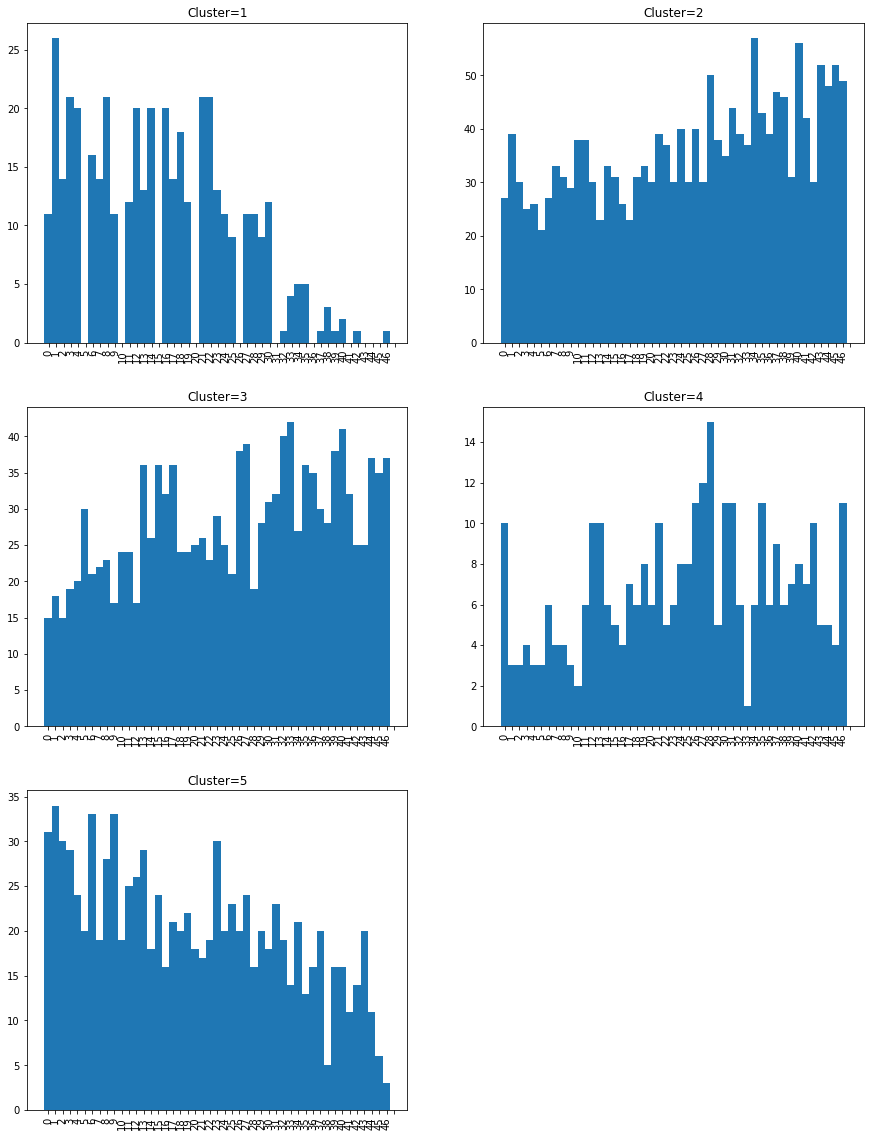

In [45]:
Z = linkage(X, "ward")
k=5
clusters = fcluster(Z, k, criterion='maxclust')
plot_by_cluster(clusters, eq_publish_date)

##### Comment

### K-Means clustering

We also wanted to explore one more clustering algorithms as we did with the hierarchical clustering. This time over the *feature vectors*. We found a [GPU implementation of K-means++ and K-NN](https://github.com/src-d/kmcuda) and we applied it varying parameters.

We had to run on 16bit precisions vectors otherwise computations and memory bandwidth of our graphic adapter was saturated. We wanted to run it with the 4096-dimensions vectors but again is was too heavy. Here are the settings we tried

* We ran PCA to get vectors of dimension `[128,256,512,1024,2048]`
* We asked for `[10, 20, 30, 70, 80, 100, 200]` clusters. Since with 400'000 books we it would still group in average 2000 books in a cluster, we even pushed to 500, 1000, 2000, 3000, 4000 clusters
* Then we have visually inspected the content of different cluster in a 3d surface plot with as X axis the category and as Y axis the year to find some relationship. We plotted them with and without normalized Z axis (forced between 0 and 1).

We did not find anything and books were not clustered because of this criteria. At first sight we had doubts it would work since the only metrics proposed with this implementation was Euclidean distance and over all metrics we tested for the hierarchical clustering, Ward was the best of them.

We display here some results tractable for a notebook format.

We use the same scales as before to show clusters compositions. Notice that they are not normalized and thus the Z scale is not the same. The idea is to see that there is no pattern driven by years or categories on those clusters and from our observations changing the 

* precision of the algorithm (#assignment changes threshold before stopping)
* amount of clusters
* dimension of PCA

did not influence any of those cluster constructions.

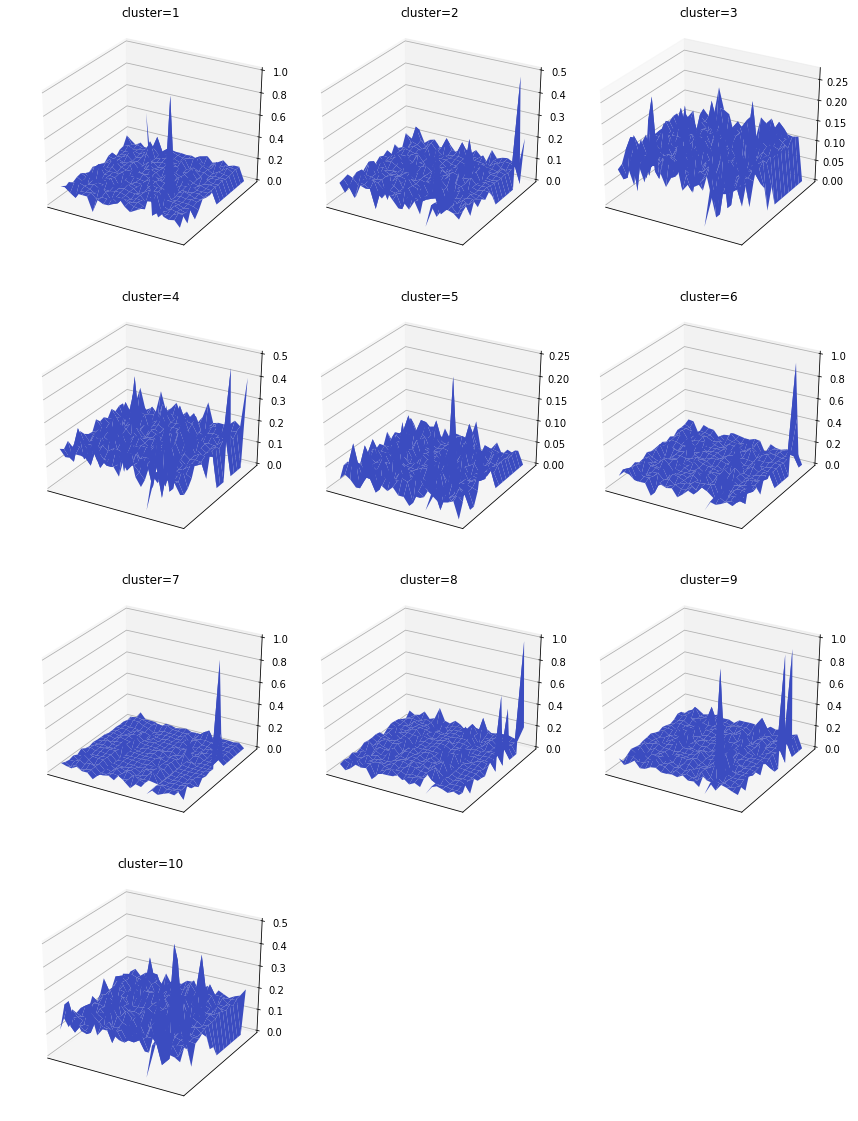

In [66]:
from cluster_utils import load_for, grid_for_cluster, figsize_for_cluster

cluster_size = 10
for dimension in [128]: # possible to add 256,512,1024 here
    zs = load_for(dimension, cluster_size, graph_data)
    
    grid = grid_for_cluster[cluster_size]
    rows, columns = grid
    figsize =  figsize_for_cluster(grid)
    fig = plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=0.2, wspace=0)
    
    
    for x in range(cluster_size):
        ax = fig.add_subplot(rows, columns, x + 1, projection='3d')
        plot_3d(ax, zs[x], title="cluster={}".format(x + 1), graph_data=graph_data, hide_ticks=True)
plt.show()

## Classification
We decided to try and predict a book's category using only its cover (in the form of our vectors), whithout any naural language processing whatsoever. We tried two techniques for this classification, SVC and a Convolutional Neural Network. Here is how we implemented both approaches.

### SVC

This Support Vector Classification is done with the scikit-learn library. After some trials we set our model with a Radial Basis Function kernel and a one-against-one function for multi-class classification.
As SVM takes some time to compute we also tried to reduce the amount of features in our cover vectors with PCA, selecting only the best components. This is only one of the cross-validation run for this model, see the Report for more results.

In [4]:
#Import features
dataset = list()
features = list()

with open("dataset_basic_categories.txt", "r") as f:
    for l in f:
        asin, category = l.strip().split("😱")
        dataset.append((asin, category))
        
with open("dataset_basic_categories.features", "rb") as f:
    while True:
        floats = f.read(4 * 4096)
        try:
            features.append(np.fromstring(floats, dtype=np.float32, count=4096))
        except ValueError:
            break

In [5]:
#Create labels
labels = []
for x in dataset:
    if x[1] == 'Agriculture':
        labels.append(0)
    if x[1] == 'Auxiliary Sciences of History':
        labels.append(1)
    if x[1] == 'Fine Arts':
        labels.append(2)

In [6]:
#Selecting 1000 principal components
pca = PCA(n_components=1000)
pca.fit(features)
X = pca.fit_transform(features)

In [ ]:
#Running 3-fold cross-validation
clf_1000_features = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(clf_1000_features, X, labels, n_jobs=-1)
scores

array([ 0.69630746,  0.70129381,  0.7071608 ])

In [10]:
np.mean(scores)

0.70158735725593857

Here we can see that we reach an average accuracy of 70.16% using 23'000 books balanced over 3 categories: *Agriculture*, *Auxiliary Sciences of History* and *Fine Arts*. After doing the same thing with more books and adding 2 more categories: *Medicine* and *Geography, Anthropology, and Recreation*, we reach an accuracy of 54.81%, meaning that the accuracy drops quickly when adding more categories. As a more concrete exemple here we fit this 5 categories model on 80% of the data (40'000 books this time) and test it:

In [21]:
#Import features
dataset = list()
features = list()

with open("dataset_basic_categories.expanded1.txt", "r") as f:
    for l in f:
        asin, category = l.strip().split("😱")
        dataset.append((asin, category))
        
with open("dataset_basic_categories.expanded1.features", "rb") as f:
    while True:
        floats = f.read(4 * 4096)
        try:
            features.append(np.fromstring(floats, dtype=np.float32, count=4096))
        except ValueError:
            break

In [22]:
#Create labels
labels = []
for x in dataset:
    if x[1] == 'Agriculture':
        labels.append(0)
    elif x[1] == 'Auxiliary Sciences of History':
        labels.append(1)
    elif x[1] == 'Fine Arts':
        labels.append(2)
    elif x[1] == 'Medicine':
        labels.append(3)
    elif x[1] == 'Geography, Anthropology, and Recreation':
        labels.append(4)
    else:
        print('noooo')

In [23]:
#Selecting 1000 principal components
pca = PCA(n_components=1000)
pca.fit(features)
X = pca.fit_transform(features)

In [24]:
#Split the data into train/test with size 80%-20% respectively
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [25]:
#Fit model
clf_1000_features = svm.SVC(kernel='rbf', C=1, decision_function_shape='ovo')
clf_1000_features.fit(X_train, y_train)  

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
#Test model
preds = clf_1000_features.predict(X_test)

Here is the confusion matrix:

In [29]:
#Code from the scikit-learn library examples
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

In [32]:
cnf_matrix = confusion_matrix(y_test, preds)
np.set_printoptions(precision=2)

TypeError: 'numpy.ndarray' object is not callable

In [31]:
# Plot normalized confusion matrix
class_names=['Agriculture', 'Auxiliary Sciences of History', 'Fine Arts', 'Medicine', 'Geography, Anthropology, and Recreation']
class_names=[x.split(",")[0] for x in class_names]
x = plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
x.savefig('normalized_conf_mat_5cat')

NameError: name 'cnf_matrix' is not defined

### CNN

#### Models and files

* To do the training, we relied on the facilities provided by the Keras framework.
* We needed to move around our resized dataset (6.1 GB of data)
* We used the [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator) which is capable to fetch automatically images from a folders hierarchy to generate a test and training set.
    * this hierarchy is build in this way: `/data/[CLASS]/[SAMPLE]` where [CLASS] is a placeholder for the class, i.e. 2000, 2001, 2002, 2003 and [SAMPLE] a placeholder for an image filename, i.e. `/data/2002/asdfasdfa.jpg`.
    * Since we created many training and test sets, we relied on symlinks on Linux with the script shown below

#### By years

The multiple executions of the hierarchical clustering taught us that they were some relationship between some clusters and categories and years. Also, this methods did not scale up and took too much time to be interactive and for exploratory purpose. So to fullfill our first research questions, we tried other methods:

* Basic 3-layers CNN classification by years
* Pretrained Xception CNN model classification by years

##### Basic 3-layers CNN

Our first model was inspired by the tutorial [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

Sequentially:

1. 2D convolutation layer with **32** (3,3) filters, **relu** activation
2. 2D max pooling layer with pool size (2,2)
3. 2D convolutation layer with **32** (3,3) filters, **relu** activation
4. 2D max pooling layer with pool size (2,2)
5. 2D convolutation layer with **64** (3,3) filters, **relu** activation
6. 2D max pooling layer with pool size (2,2)
7. Fully connected layer with **variables numbers** cells, **relu** activation
8. Fully connected layer with **9** cells, **softmax** acitvation

We tried to produce a balanced dataset of 126'520 images from 2000 to 2009. Here is the distribution of the data. Unfortunately, we never obtained more than 11.5% of accuracy with this model. Which is just above a random choices (1/9=11.11%)

In [ ]:
import os

def create_symlinks(dataset, folder, dataset_folder="dataset"):
    for _, class_, file in dataset:
        source_folder, basename = os.path.split(file)
        
        # on the fly filtering
        if type(class_) == type(2) and class_ < 2000:
            continue

        resized_file = os.path.abspath(file)
        destination_folder = os.path.join(dataset_folder, folder, str(class_))
        destination_file = os.path.join(destination_folder, basename)

        os.makedirs(destination_folder, exist_ok=True)

        if not os.path.isfile(destination_file):
            os.symlink(resized_file, destination_file)

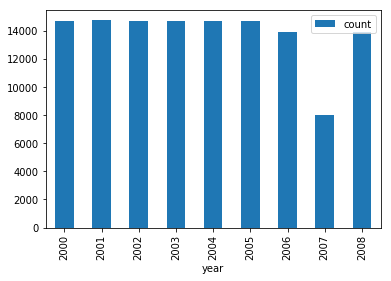

In [68]:
#  puts "[#{(2000..2008).map{ |y| "[#{y},#{`find train/#{y}/ -type l | wc -l`.strip.to_i}]" }.join(",\n  ")}]"
data = [
    [2000,14695],
    [2001,14734],
    [2002,14675],
    [2003,14672],
    [2004,14691],
    [2005,14690],
    [2006,13913],
    [2007,8002],
    [2008,13882]
]

df = pd.DataFrame(data, columns=["year", "count"])
df = df.set_index("year")
df.plot.bar()
plt.show()

##### Xception transfer learning CNN

* Reference: [Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/abs/1610.02357)
* We tested the following settings:
    * with only a fully connected layer with 9 outputs
    * with an extra fully connected layer: `[16,32,64,128,256,512,1024]` cells
    
We then decided to rely on pretrained convolutational network offered by the Keras library. The idea was to freeze the already trained part and add two fully connected layers at the output. It relies on transfer learning. We did many exploratory tests and presents the results for the variation of the size of the intermediate fully connected layer. We tried values [0 (absence of), 16, 32, 64, 128, 256, 512, 1024].

Our best accuracy was the following. Given 2 epochs with each settings (it takes a long time to train on a GPU):

| numbers of neurons in the intermediate layers | best validation accuracy |
|-----------------------------------------------|--------------------------|
| 0 (absence of intermediate layer)             | 14.00%                   |
| 16                                            | 12.04%                   |
| 32                                            | 13.76%                   |
| 64                                            | 13.92%                   |
| 128                                           | 14.86%                   |
| 256                                           | 14.51%                   |
| 512                                           | 14.59%                   |
| 1024                                          | 14.67%                   |

And the confusion matrix for a random test set

Normalized confusion matrix
[[ 0.37704918  0.06885246  0.07868852  0.00327869  0.04262295  0.1147541
   0.04590164  0.          0.26885246]
 [ 0.30827068  0.12406015  0.09774436  0.0075188   0.06766917  0.15413534
   0.04887218  0.          0.19172932]
 [ 0.28307692  0.09230769  0.07384615  0.00615385  0.04        0.16923077
   0.09538462  0.          0.24      ]
 [ 0.29878049  0.04878049  0.07926829  0.00304878  0.03658537  0.16463415
   0.08841463  0.          0.2804878 ]
 [ 0.29449838  0.06796117  0.02912621  0.00323625  0.05177994  0.17799353
   0.05501618  0.          0.32038835]
 [ 0.19354839  0.0483871   0.07419355  0.00645161  0.03548387  0.16774194
   0.11290323  0.          0.36129032]
 [ 0.2543554   0.05923345  0.05226481  0.          0.02090592  0.13240418
   0.08013937  0.          0.40069686]
 [ 0.2037037   0.04320988  0.08024691  0.          0.02469136  0.14197531
   0.14814815  0.          0.35802469]
 [ 0.23722628  0.05109489  0.04379562  0.          0.02189781  0.1350

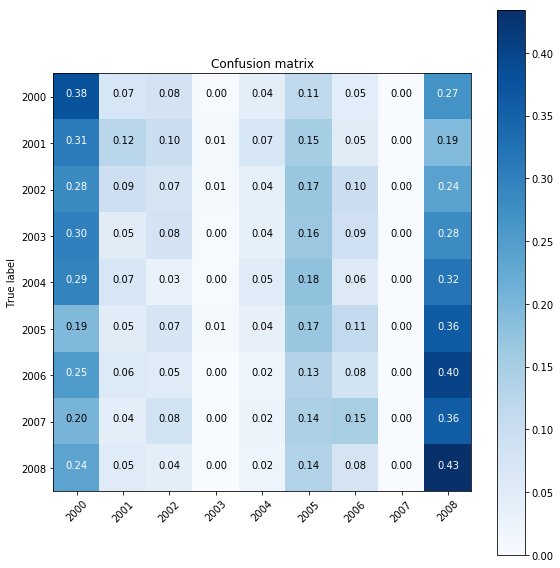

In [71]:
confusion_matrix = np.array([[115,  21,  24,   1,  13,  35,  14,   0,  82,],
 [ 82,  33,  26,   2,  18,  41,  13,   0,  51,],
 [ 92,  30,  24,   2,  13,  55,  31,   0,  78,],
 [ 98,  16,  26,   1,  12,  54,  29,   0,  92,],
 [ 91,  21,   9,   1,  16,  55,  17,   0,  99,],
 [ 60,  15,  23,   2,  11,  52,  35,   0, 112,],
 [ 73,  17,  15,   0,   6,  38,  23,   0, 115,],
 [ 33,   7,  13,   0,   4,  23,  24,   0,  58,],
 [ 65,  14,  12,   0,   6,  37,  21,   0, 119,]])

plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix, classes=list(map(str, range(2000, 2009))), normalize=True)
plt.show()

#### By categories

We proceeded as follow:

1. we picked three categories as orthogonal as possible and expected best result
2. we added two extra categories 
3. we added four extra categories and ended up with almost 80'000 books, a bit less than 10'000 books per category

based on the feature vectors. We tried SVM and neural network models. As indicated by the sklearn manual, [SVM is not recommended with more than 10'000 samples](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and that is what we observed with hours of training even with our simplest dataset. For our Neural nets, we simply used them to take advantage of GPU capabilities. 

We used [StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) and StandardScaler from Sklearn library. the former to create a balanced dataset given the labels automatically and to choose correctly hyperparameters for our model. The StandardScaler is recommended for neural network to have each features normalized between 0 and 1 as it was not the case for the features. For the last step we looked for the best settings by tunning:

* batch size
* number and size of intermediate layer
* dropout values

##### Three categories

We used a balanced dataset. The best result over the settings

* Batch size : [1,2,4,8,16,32,64]
* Intermediate fully connected layers size: [10,25,50,100]
* Dropout: 0.0 or 0.5
* 5 epochs, more the model was overfitting

We found out that the best settings were **batchsize=32**, **layers=50** and **dropout=0.5** and gave us **73.16%** of accuracy.   The file for this modèle can be found in `models/run3.kfold5.weights.02-0.7316.hdf5` and should be executed with `models/kfold5_run3`. Here are the number of books per category, the functioon which define the models and the confusion matrix for our best settings.

In [74]:
categories = list()

with open("dataset_basic_categories.txt", "r") as f:
    for l in f:
        _, category = l.strip().split("😱")
        categories.append(category)
        
Counter(categories)

Counter({'Agriculture': 7942,
         'Auxiliary Sciences of History': 7983,
         'Fine Arts': 7958})

In [14]:
def build_model(batch_size, layers):
    inputs = Input(shape=(4096,))

    x = Dense(layers,
              activation='relu')(inputs)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def train(X, Y, batch_size, layers):
    kf = StratifiedKFold(n_splits=12, random_state=1, shuffle=True)

    for train_index, test_index in kf.split(X):

        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        ASIN_train, ASIN_test = ASIN[train_index], ASIN[test_index]

        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        model = build_model_for_5(batch_size, layers)
        model.fit(x=X_train, y=Y_train, epochs=5, verbose=1, callbacks=[checkpoint], batch_size=batch_size, validation_data=(X_test, Y_test))

def test(model_file, kfold_file, batch_size, layers, output_file):
    """
    function used to test back an existing model
    
    model_file: path to a hdf5
    kfold_file: pickle containing a tuple of X, Y and ASIN
    output_file: path to output a CSV file with ASIN;Category;Prediction;CorrectPrediction;IsPredictionCorrect;PredictionRatioPerCategory{3}
    """
    with open(kfold_file, "rb") as f:
        X_test, Y_test, ASIN_test = pickle.load(f)
        
    model = build_model(batch_size, layers)
    model.load_weights(model_file)
    
    print(model.evaluate(X_test, Y_test))
    predictions = model.predict(x=X_test)


    Y_pred = np.argmax(predictions, axis=1)
    Y_test_sklearn = np.argmax(Y_test, axis=1)
    
    classes = ['Agriculture', 'Auxiliary Sciences of History', 'Fine Arts']
    
    predictions_2 = list()
    
    for i, (asin, category) in enumerate(ASIN_test):
        predictions_2.append((asin, category, predictions[i], max(predictions[i])))

    with open(output_file, "w") as f:
        predictions_2.sort(key=lambda x: x[3], reverse=True)
        for i, (asin, category, prediction, max_) in enumerate(predictions_2):
            model_prediction = np.argmax(prediction)
            correct_prediction = classes.index(category)
            is_correct_prediction = model_prediction == correct_prediction
            
            f.write("{};{};{};{};{};{};{};{}\n".format(asin, category, model_prediction, correct_prediction, is_correct_prediction, *prediction))
            
    return confusion_matrix(Y_test_sklearn, Y_pred)

In [15]:
confusion_matrix = test(
    "models/run3.kfold5.weights.02-0.7316.hdf5",
    "models/kfold5_run3",
    32,
    50,
    "test.3.txt"
)

2388/2388 [==============================] - 0s 46us/step
[0.67605081644888898, 0.73157453936348404]


Normalized confusion matrix
[[ 0.7086514   0.10559796  0.18575064]
 [ 0.10311751  0.76498801  0.13189448]
 [ 0.16796875  0.11328125  0.71875   ]]


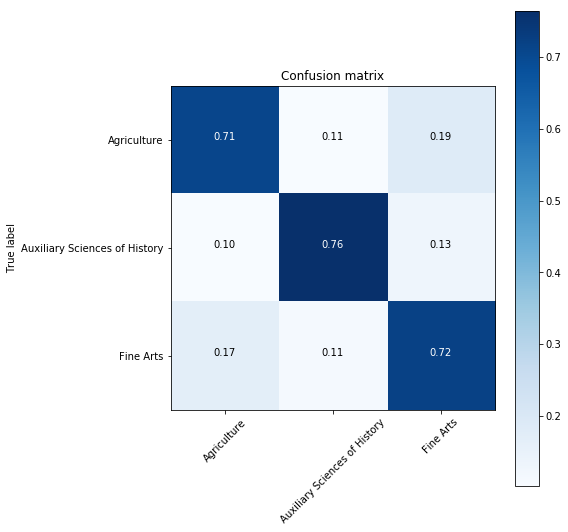

In [87]:
ticks = [x.split(",")[0] for x in ['Agriculture', 'Auxiliary Sciences of History', 'Fine Arts']]

fig = plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix, ticks, normalize=True)
plt.show()

##### Five categories

This time we made many trials and refined our previous analysis. The following parameters have been tested in depth:

* Batch size: [16,24,32,48]
* Layers: [25,37,50,75], even with two stages: [[10, 10], [12, 12], [25,25]] without success
* With 0.5 or 0 dropout

We obtained an acurracy of **55.89%** with **layers=75** and **batchsize=32**. The file for this model can be found in `models/run5.dropoutTrue.batch32.layers75.kfold4.weights.03-0.5589.hdf5` and should be executed with `models/kfold4_run5` file.

In [35]:
def build_model(batch_size, layers, dropout, nb_classes=5):
    inputs = Input(shape=(4096,))
    
    # support multiple stage layers
    if layers == 0:
        layers = []
    elif type(layers) == type(2):
        layers = [layers]

    x = inputs

    for layer in layers:
        x = Dense(layer,activation='relu')(inputs)
    if dropout is True:
        x = Dropout(0.5)(x)
    elif dropout is False:
        pass
    else:
        x = Dropout(dropout)(x)
    predictions = Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


def test(model_file, kfold_file, batch_size, layers, dropout, nb_classes, output_file):
    """
    function used to test back an existing model
    
    model_file: path to a hdf5
    kfold_file: pickle containing a tuple of X, Y and ASIN
    output_file: path to output a CSV file with ASIN;Category;Prediction;CorrectPrediction;IsPredictionCorrect;PredictionRatioPerCategory{3}
    """
    with open(kfold_file, "rb") as f:
        X_test, Y_test, ASIN_test = pickle.load(f)
        
    model = build_model(batch_size, layers, dropout, nb_classes)
    model.load_weights(model_file)
    
    print(model.evaluate(X_test, Y_test))
    predictions = model.predict(x=X_test)

    Y_pred = np.argmax(predictions, axis=1)
    Y_test_sklearn = np.argmax(Y_test, axis=1)
    
    classes = list()
    
    if nb_classes == 9:
        classes = ['Agriculture', 'Auxiliary Sciences of History', 'Fine Arts',
 'Geography, Anthropology, and Recreation', 'Medicine', 'Music',
 'Philosophy, Psychology, and Religion', 'Science', 'Technology']
    else:
        classes = ['Agriculture', 'Auxiliary Sciences of History', 'Fine Arts',
 'Geography, Anthropology, and Recreation', 'Medicine']
    
    predictions_2 = list()
    
    for i, (asin, category) in enumerate(ASIN_test):
        predictions_2.append((asin, category, predictions[i], max(predictions[i])))

    with open(output_file, "w") as f:
        predictions_2.sort(key=lambda x: x[3], reverse=True)
        for i, (asin, category, prediction, max_) in enumerate(predictions_2):
            model_prediction = np.argmax(prediction)
            correct_prediction = classes.index(category)
            is_correct_prediction = model_prediction == correct_prediction
            
            args = [asin, category, model_prediction, correct_prediction, is_correct_prediction, *prediction]
            pattern = ";".join(["{}"] * len(args)) + "\n"
            f.write(pattern.format(*args))
            
    return confusion_matrix(Y_test_sklearn, Y_pred)
            
confusion_matrix = test(
    "models/run5.dropoutTrue.batch32.layers75.kfold4.weights.03-0.5589.hdf5",
    "models/kfold4_run5",
    32,
    75,
    0.5,
    5,
    "test.5.txt"
)

4974/4974 [==============================] - 0s 59us/step
[1.1940069198129069, 0.55890631282669878]


In [36]:
confusion_matrix

array([[541,  40, 122, 152, 122],
       [ 68, 570,  88, 137,  94],
       [111,  61, 579, 154, 120],
       [138,  90, 176, 427, 171],
       [ 72,  48,  82, 148, 663]])

Normalized confusion matrix
[[ 0.55373593  0.04094166  0.12487206  0.1555783   0.12487206]
 [ 0.07105538  0.59561129  0.09195402  0.14315569  0.09822362]
 [ 0.10829268  0.0595122   0.56487805  0.1502439   0.11707317]
 [ 0.13772455  0.08982036  0.1756487   0.4261477   0.17065868]
 [ 0.07107601  0.04738401  0.08094768  0.14610069  0.65449161]]


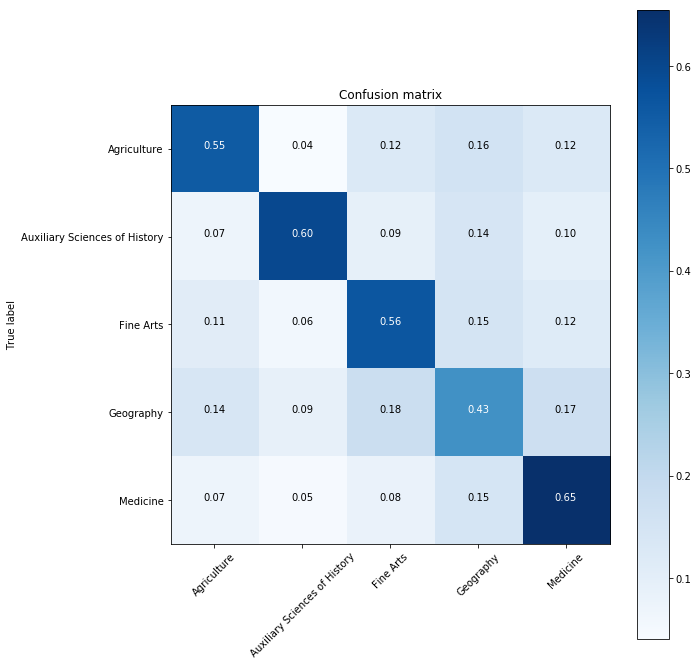

In [37]:
ticks = [x.split(",")[0] for x in ['Agriculture', 'Auxiliary Sciences of History', 'Fine Arts',
 'Geography, Anthropology, and Recreation', 'Medicine']]


fig = plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, ticks, normalize=True)
plt.show()

##### Nine categories

This time we made many trials and refined our previous analysis. The following parameters have been tested in depth:

* Batch size: [16,24,32,48,64,128,256,512,1024]
* Layers: [25,37,50,75]
* Dropout: [0,0.125,0.25,0.5]

The file for this model can be found in `models/run10.dropout0.25.batch64.layers60.kfold8.weights.02-0.3751.hdf5` and should be ran with `models/kfold8_run10` file

In [46]:
confusion_matrix = test(
    "models/run10.dropout0.25.batch64.layers60.kfold8.weights.02-0.3751.hdf5",
    "models/kfold8_run10",
    64,
    60,
    0.25,
    9,
    "test.9.txt"
)

6633/6633 [==============================] - 0s 50us/step
[1.783433908864813, 0.37509422587643881]


TypeError: 'numpy.ndarray' object is not callable

Normalized confusion matrix
[[ 0.45166163  0.03625378  0.10120846  0.07854985  0.05891239  0.05287009
   0.10422961  0.05438066  0.06193353]
 [ 0.03070761  0.56341789  0.06008011  0.06408545  0.05206943  0.10413885
   0.09212283  0.01201602  0.02136182]
 [ 0.03887399  0.04959786  0.48927614  0.0536193   0.03351206  0.09383378
   0.13136729  0.04691689  0.06300268]
 [ 0.0536193   0.09517426  0.10589812  0.28552279  0.0924933   0.10053619
   0.16621984  0.03485255  0.06568365]
 [ 0.03887399  0.03887399  0.04557641  0.05227882  0.42761394  0.05093834
   0.18766756  0.07908847  0.07908847]
 [ 0.0295302   0.12080537  0.12080537  0.10201342  0.06845638  0.2442953
   0.20805369  0.06174497  0.0442953 ]
 [ 0.04417671  0.08299866  0.10575636  0.0562249   0.15930388  0.07630522
   0.39759036  0.03614458  0.04149933]
 [ 0.07630522  0.04685408  0.09906292  0.06425703  0.16198126  0.06024096
   0.1793842   0.24096386  0.07095047]
 [ 0.06174497  0.04026846  0.1409396   0.08187919  0.10738255  0.0724

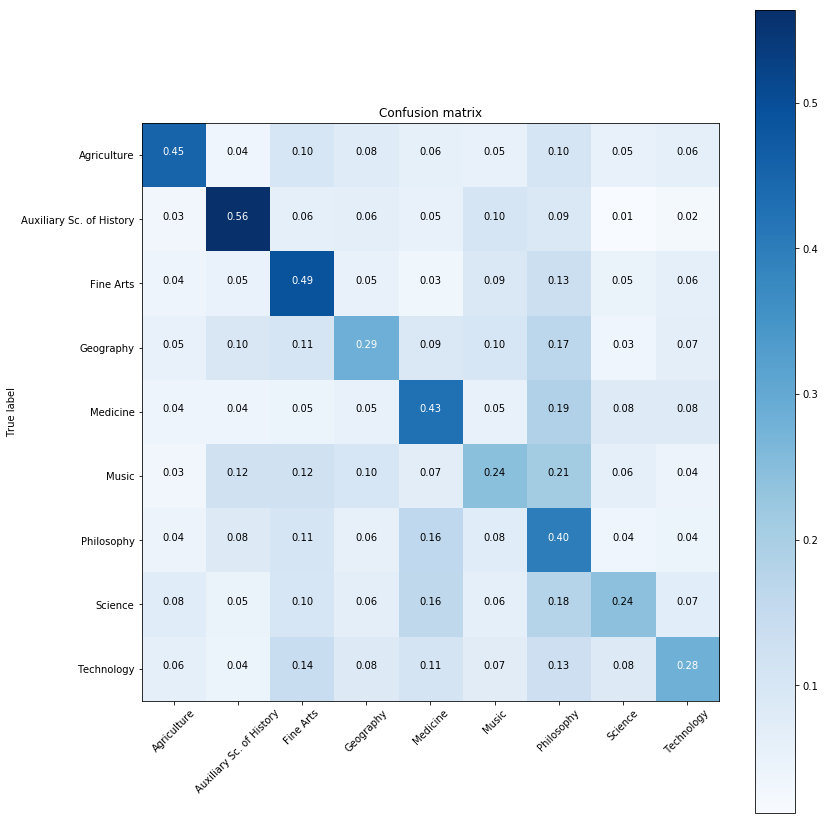

In [76]:
confusion_matrix = np.array([[299,  24,  67,  52,  39,  35,  69,  36,  41],
 [ 23, 422,  45,  48,  39,  78,  69,   9,  16],
 [ 29,  37, 365,  40,  25,  70,  98,  35,  47],
 [ 40,  71,  79, 213,  69,  75, 124,  26,  49],
 [ 29,  29,  34,  39, 319,  38, 140,  59,  59],
 [ 22,  90,  90,  76,  51, 182, 155,  46,  33],
 [ 33,  62,  79,  42, 119,  57, 297,  27,  31],
 [ 57,  35,  74,  48, 121,  45, 134, 180,  53],
 [ 46,  30, 105,  61,  80,  54,  96,  62, 211]])

ticks = [x.split(",")[0] for x in ['Agriculture', 'Auxiliary Sc. of History', 'Fine Arts',
 'Geography, Anthropology, and Recreation', 'Medicine', 'Music',
 'Philosophy, Psychology, and Religion', 'Science', 'Technology']]

plt.figure(figsize=(12,12))
plot_confusion_matrix(confusion_matrix, ticks, normalize=True)
plt.show()

# Example of well classified images 

We present here some well classified example for each of the nine category to let the reader observes some similarity among the covers

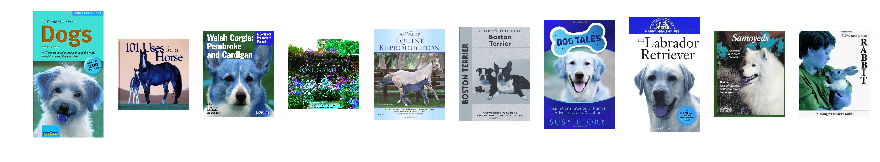

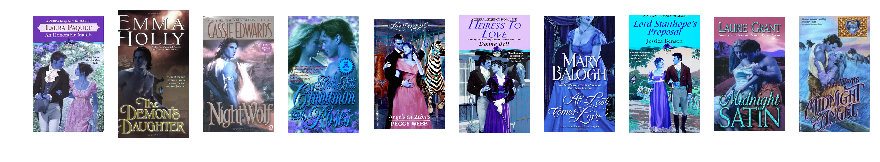

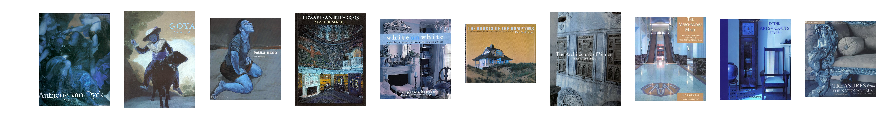

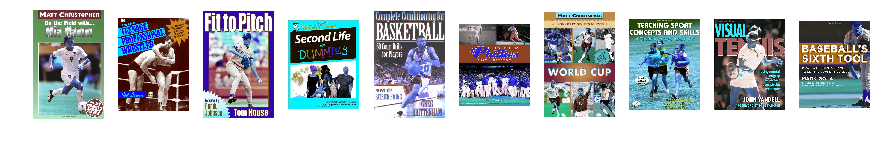

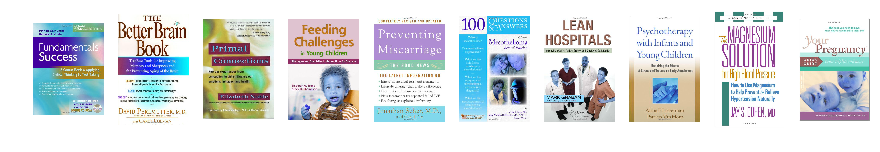

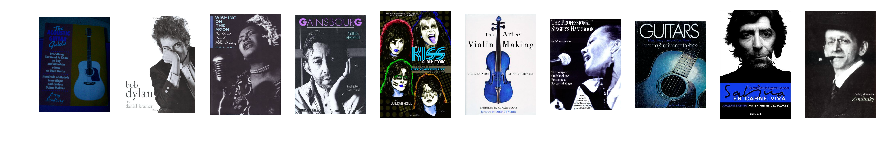

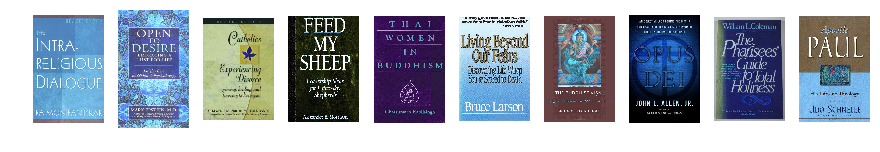

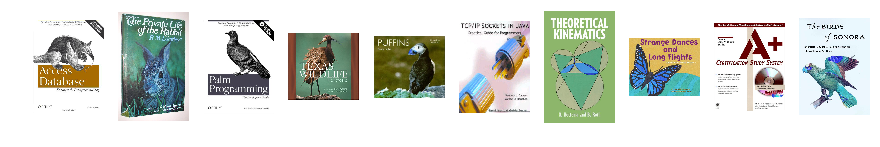

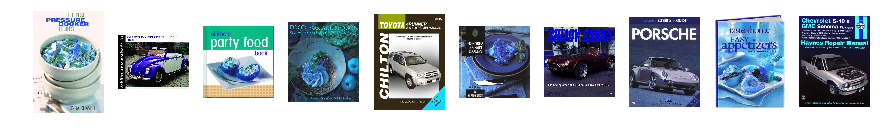

In [45]:
predictions = []

# prediction_output_run9.2.txt is an output file of the above test() methods
with open('prediction_output_run9.2.txt', 'r') as f:
    for l in f: 
        splitted = str(l).strip().split(';')
        
        asin = splitted[0]
        true_class_index = splitted[3]
        
        true_class_index = int(true_class_index)
        certitude = float(splitted[5+int(splitted[3])])
        
        predictions.append((asin, true_class_index, certitude))

        
for class_index in range(9):
    plt.figure(figsize=(15, 10))
    count = 0
    
    for asin, true_class_index, certitude in predictions:
        if true_class_index == class_index and certitude > 0.5:
            img = cv2.imread(main_dataset.loc[asin]['file'].strip('../').replace('resized/', ''))
            if img is not None:
                plt.subplot(1,10,count+1) 
                plt.imshow(img)
                plt.axis('off')
                count += 1
            if count == 10: 
                plt.show()
                break